# Read Data

In [4]:
import pandas as pd
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from functools import partial
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import json
import requests

In [5]:
# API of Cryptographic currency in json format
url = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(url + '?fsym=BTC&tsym=USD&limit=2000')
# AUD train model时，会出现loss = NAN的情况。但是不知道为什么
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
hist.head()

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2013-05-30,128.80,132.40,126.50,132.25,24699.41,3195601.21
2013-05-31,128.82,130.00,126.33,128.80,16576.17,2124938.29
2013-06-01,129.30,129.79,127.10,128.82,6357.50,816323.15
2013-06-02,122.50,130.10,115.00,129.30,101134.67,12335011.09
2013-06-03,120.74,122.78,115.11,122.50,28898.42,3439235.99


### Transform dataset to one feature

In [6]:
ts = hist['close']
ts.head()

time
2013-05-30    128.80
2013-05-31    128.82
2013-06-01    129.30
2013-06-02    122.50
2013-06-03    120.74
Name: close, dtype: float64

### ARIMA Stationary test

In [7]:
def testStationarity(ts):
    dftest = adfuller(ts)
    # 对上述函数求得的值进行语义描述
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

In [8]:
# not Stationarity
testStationarity(ts)

Test Statistic                   -1.891696
p-value                           0.335977
#Lags Used                       20.000000
Number of Observations Used    1980.000000
Critical Value (1%)              -3.433657
Critical Value (5%)              -2.863001
Critical Value (10%)             -2.567548
dtype: float64

### first difference

In [9]:
ts_diff = ts.diff(1).dropna()

In [10]:
# stationary
testStationarity(ts_diff)

Test Statistic                -8.154092e+00
p-value                        9.522637e-13
#Lags Used                     2.600000e+01
Number of Observations Used    1.973000e+03
Critical Value (1%)           -3.433669e+00
Critical Value (5%)           -2.863006e+00
Critical Value (10%)          -2.567550e+00
dtype: float64

### Draw acf & pcaf

In [11]:
# 自相关和偏相关图，默认阶数为31阶
def draw_acf_pacf(ts, lags=31):
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    plot_acf(ts, lags=31, ax=ax1)
    ax2 = f.add_subplot(212)
    plot_pacf(ts, lags=31, ax=ax2)
    plt.show()

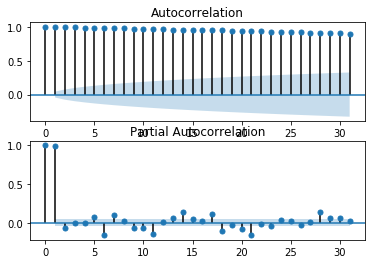

In [12]:
draw_acf_pacf(ts)

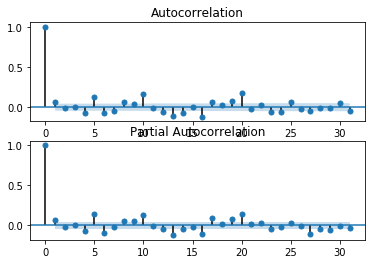

In [13]:
draw_acf_pacf(ts_diff)

**初步认为，p=2, q = 2**

### Split train and test data

In [14]:
from datetime import datetime,timedelta
import pandas as pd
date = datetime(year=2018, month=6, day=18)
date_end = date+timedelta(days=6)

In [15]:
# train
dataset = ts[:date]
# test
validation = pd.DataFrame(ts[date:date_end])

### Model

In [16]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
from statsmodels.tsa.arima_model import ARIMA
# fit model
model = ARIMA(ts, order=(2,1,2))
# disp controls the frequency of the output during the iterations. disp < 0 means no output in this case.
model_fit = model.fit()
# multi-step out-of-sample forecast
forecast = model_fit.forecast(steps=7)[0]
perdict = model_fit.predict(start =date,end =date_end)

In [17]:
dataset[-1]

6714.82

In [18]:
perdict

2018-06-18   -20.385076
2018-06-19    32.638879
2018-06-20   -24.114457
2018-06-21    22.206493
2018-06-22   -19.559317
2018-06-23   -35.022951
2018-06-24    30.123336
Freq: D, dtype: float64

In [19]:
diff_sum = perdict.cumsum()
diff_sum

2018-06-18   -20.385076
2018-06-19    12.253803
2018-06-20   -11.860653
2018-06-21    10.345840
2018-06-22    -9.213477
2018-06-23   -44.236428
2018-06-24   -14.113091
Freq: D, dtype: float64

In [20]:
perdict = dataset[-1] + diff_sum
perdict

2018-06-18    6694.434924
2018-06-19    6727.073803
2018-06-20    6702.959347
2018-06-21    6725.165840
2018-06-22    6705.606523
2018-06-23    6670.583572
2018-06-24    6700.706909
Freq: D, dtype: float64

In [21]:
forecast

array([4977.80082945, 4938.49329828, 4960.07356281, 4937.68942976,
       4949.01775663, 4936.30747931, 4942.31004245])

In [22]:
print('forecast RMSE: %.4f'% np.sqrt(mean_squared_error(forecast,validation)))
print('predict RMSE:%.4f'%np.sqrt(mean_squared_error(perdict.values,validation)))

forecast RMSE: 1553.6472
predict RMSE:374.3112


In [30]:
from sklearn.metrics import mean_squared_error
def plot_comparision(true, predict,preds):
    fig, ax = plt.subplots(1, figsize=(6, 4))
    x_date = [i for i in true.index]
    ax.plot(x_date,predict,color='blue', label='Forecast')
    ax.plot(x_date,true,color='red', label='Original')
    ax.plot(x_date,preds,color='green', label='Predict')
    plt.legend(loc='best')
    plt.xticks(rotation=60)
    plt.title('RMSE: %.4f'% np.sqrt(mean_squared_error(predict.values,true.values))+'\n'+
             'predict RMSE: %.4f'% np.sqrt(mean_squared_error(preds.values,true.values)))
    plt.show()

In [24]:
forecast = pd.DataFrame(forecast)
forecast['time'] = validation.index
forecast = forecast.set_index('time')
forecast.columns = ['prediction']

In [29]:
perdict

2018-06-18    6694.434924
2018-06-19    6727.073803
2018-06-20    6702.959347
2018-06-21    6725.165840
2018-06-22    6705.606523
2018-06-23    6670.583572
2018-06-24    6700.706909
Freq: D, dtype: float64

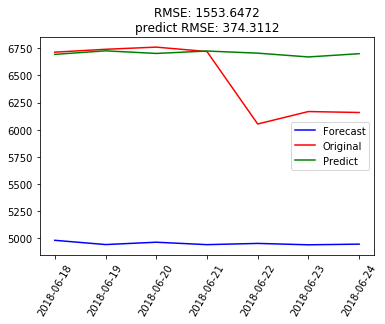

In [31]:
plot_comparision(validation, forecast,perdict)

### Next ->  Log + difference

# Reference

https://machinelearningmastery.com/make-sample-forecasts-arima-python/

- How to make a one-step out-of-sample forecast.
- How to make a multi-step out-of-sample forecast.
- The difference between the forecast() and predict() functions.

https://towardsdatascience.com/time-series-forecasting-arima-models-7f221e9eee06

- P = Periods to lag for eg: (if P= 3 then we will use the three previous periods of our time series in the autoregressive portion of the calculation) P helps adjust the line that is being fitted to forecast the series